In [1]:
import healpy as hp
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from glob import glob
from astropy.table import Table, vstack

In [2]:
import sys
sys.path.append('/global/homes/a/arosado/LSSutils/')
from lssutils import setup_logging, CurrentMPIComm
#from lssutils.lab import get_meandensity
from lssutils.utils import npix2nside, make_hp
from lssutils.utils import maps_dr9 as columns

In [3]:
print(columns)

['EBV', 'STARDENS', 'galdepth_rmag_ebv', 'galdepth_gmag_ebv', 'galdepth_zmag_ebv', 'psfdepth_rmag_ebv', 'psfdepth_gmag_ebv', 'psfdepth_zmag_ebv', 'psfdepth_w1mag_ebv', 'psfdepth_w2mag_ebv', 'PSFSIZE_R', 'PSFSIZE_G', 'PSFSIZE_Z']


In [4]:
regions = ['bmzls','ndecals','sdecals']
region = regions[0]

data = glob(f'/global/cscratch1/sd/arosado/nlrg_features_*_256.fits')
windows = glob(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_*.hp256.fits')
nn = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nn-weights.hp256.fits', verbose=False, dtype=None)
#ngal_pred = ft.read(f'/global/cscratch1/sd/arosado/test_sysnet/{region}_256/windows/window_model_0_2185937781_snapshot_{ind}.fits')

In [5]:
# stack all regions:
tables = []
for d_fn in data:
    d = Table.read(d_fn)
    #print(len(d))
    tables.append(d)
tables = vstack(tables) 

In [6]:
ngal = tables['label']
nran = tables['fracgood']
mask = np.ones_like(ngal, '?')
sysm = tables['features']

hpix = tables['hpix']

# Mean Density

In [7]:
help(get_meandensity)

Help on function get_meandensity in module lssutils.stats.nnbar:

get_meandensity(ngal, nran, mask, systematics, selection_fn=None, njack=0, nbins=8, columns=None, comm=None, **kwargs)



## Get and save mean density lists

```
# for combined windows
from time import time

output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/results'

col_i = 0 # EBV
print(f'feature: {columns[col_i]}')

fig = plt.gcf()
fig.set_size_inches(7, 5)

t0 = time()
for i in range(100):
    print(f'running {i+1}/100')
    nn = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_{i}.hp256.fits', 
                     verbose=False, dtype=None)[hpix]
    
    nnbar_ls= get_meandensity(nran*nn, nran, mask, sysm, 
                              columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                              global_nbar=True)
    
    plt.plot(nnbar_ls[col_i]['nnbar'], alpha=0.2, color='r')
    
    output_fn = f'{output_dir}/nnbar_list_{i}.hp256.npy'
    print(f'saving {output_fn}')
    np.save(output_fn, nnbar_ls)
    print(f'time elapsed {time()-t0} s')
    
print(f'finished at {time()-t0} s')

plt.plot([],[],alpha=0.2, color='r', label='NN')
plt.plot(nnbar_list[col_i]['nnbar'], color='k', label='data')
plt.plot(nnbar_ls_mean[col_i]['nnbar'], color='r',ls='--', label='NN-mean (1000)')
plt.legend()
plt.show()
```

## Compare data to NN results 

In [9]:
nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                             columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                             global_nbar=True, njack=20)

In [10]:
nnbar_ls_mean = get_meandensity(nran*nn[hpix], nran, mask, sysm, 
                              columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                              global_nbar=True)

In [11]:
nnbar_list[0]

{'nnbar': array([0.98063892, 1.00120101, 1.01478254, 1.01894318, 1.02377005,
        1.04194205, 1.05117143, 1.06099078]),
 'area': array([118750.09745718,  94684.39120042,  49602.89909972,  24551.80344775,
         13574.46008137,   7219.18273501,   4014.67486642,   2257.25143343]),
 'nnbar_err': array([0.00294747, 0.00443361, 0.0055943 , 0.00501813, 0.00485671,
        0.00661379, 0.00890286, 0.00943528]),
 'bin_edges': array([0.00850642, 0.02840446, 0.0483025 , 0.06820054, 0.08809858,
        0.10799662, 0.12789466, 0.1477927 , 0.16769074]),
 'bin_avg': array([0.01920688, 0.03742066, 0.05707909, 0.07712026, 0.09711333,
        0.11671571, 0.13702038, 0.15685519]),
 'attr': {'njack': 20,
  'nbar': 31.779743661989887,
  'npix2area': 1.1169656215253787},
 'sys': 'EBV'}

feature: EBV
finished at 2.053887367248535 s


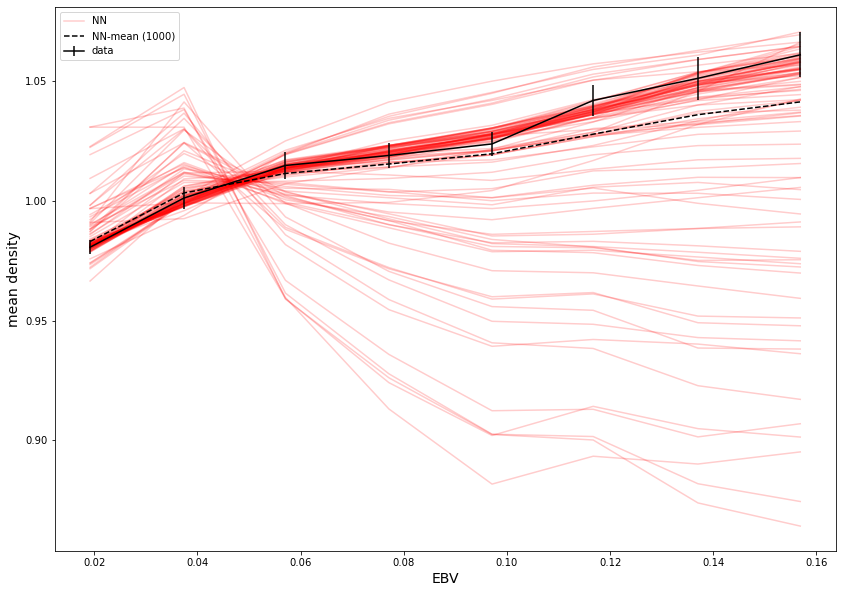

In [12]:
from time import time

output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/results'

col_i = 0 # EBV
print(f'feature: {columns[col_i]}')

fig = plt.gcf()
fig.set_size_inches(14, 10)

t0 = time()
for i in range(100):
    nnbar_ls = np.load(f'{output_dir}/nnbar_list_{i}.hp256.npy', allow_pickle=True)

    plt.plot(nnbar_ls[col_i]['bin_avg'], nnbar_ls[col_i]['nnbar'], alpha=0.2, color='r')
    
print(f'finished at {time()-t0} s')

plt.ylabel(r'mean density', fontsize=14)
plt.xlabel(f'{columns[col_i]}', fontsize=14)
plt.plot([],[],alpha=0.2, color='r', label='NN')
plt.errorbar(nnbar_list[col_i]['bin_avg'], nnbar_list[col_i]['nnbar'], nnbar_list[col_i]['nnbar_err'], color='k', label='data')
plt.plot(nnbar_ls_mean[col_i]['bin_avg'], nnbar_ls_mean[col_i]['nnbar'], color='k',ls='--', label='NN-mean (1000)')
plt.legend()
plt.show()

# Looking at Bad Models

In [7]:
nnbar_list = get_meandensity(ngal, nran, mask, sysm, 
                             columns=columns, selection_fn=None, binning='simple', percentiles=[1, 99],
                             global_nbar=True, njack=20)

feature: EBV
finished at 0.14928650856018066 s
Tolerance used to increase error cone: 0.00000
Number of good models: 25
Number of bad models: 75


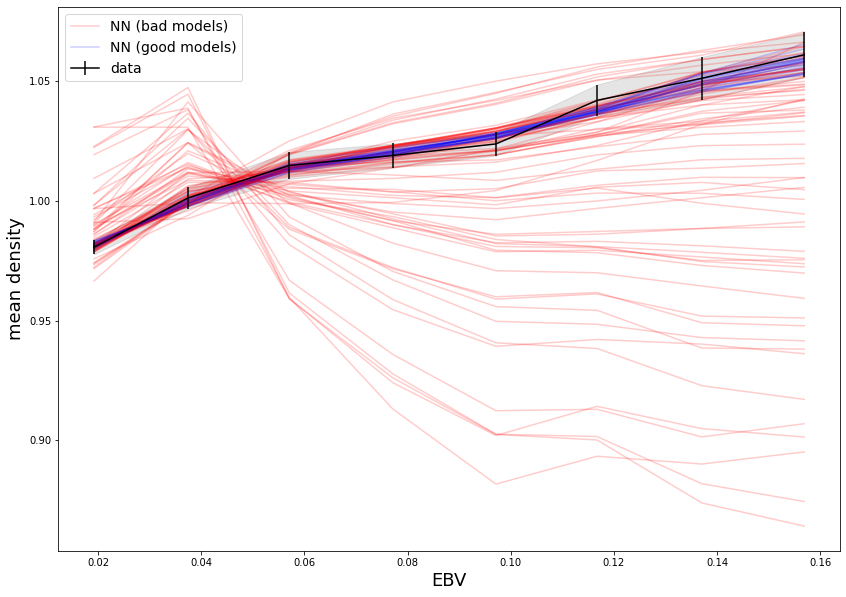

In [8]:
from time import time

output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/results'

col_i = 0 # EBV
print(f'feature: {columns[col_i]}')

fig = plt.gcf()
fig.set_size_inches(14, 10)

binavg = nnbar_list[col_i]['bin_avg']
nnbar = nnbar_list[col_i]['nnbar']
err = nnbar_list[col_i]['nnbar_err']
tol = 0.0 # 1e-3 
err_up = nnbar+(err+tol)
err_low = nnbar-(err+tol)
plt.fill_between(binavg, err_low, err_up, alpha=0.1, color='k')

good_models = []
bad_models = []

t0 = time()
for i in range(100):
    nnbar_ls = np.load(f'{output_dir}/nnbar_list_{i}.hp256.npy', allow_pickle=True)
    
    # check that result is within intervale given some error
    check = (err_low <=  nnbar_ls[col_i]['nnbar']) 
    check &= (nnbar_ls[col_i]['nnbar'] <= err_up)
    # change to check which are outside the interval
    check = ~check
    #print(check)
    
    if check.sum() == 0: # if inside interval sum should be 0
        #print('good: ', check.sum())
        good_models.append(i)
        plt.plot(nnbar_ls[col_i]['bin_avg'], nnbar_ls[col_i]['nnbar'], alpha=0.2, color='b')
    else:
        #print('bad: ', check.sum())
        bad_models.append(i)
        plt.plot(nnbar_ls[col_i]['bin_avg'], nnbar_ls[col_i]['nnbar'], alpha=0.2, color='r')
        
    
print(f'finished at {time()-t0} s')
print(f'Tolerance used to increase error cone: {tol:.5f}')
print(f'Number of good models: {len(good_models)}')
print(f'Number of bad models: {len(bad_models)}')

plt.ylabel(r'mean density', fontsize=18)
plt.xlabel(f'{columns[col_i]}', fontsize=18)
plt.plot([],[],alpha=0.2, color='r', label='NN (bad models)')
plt.plot([],[],alpha=0.2, color='b', label='NN (good models)')

plt.errorbar(binavg, nnbar, err, color='k', label='data')

plt.legend(fontsize=14)
plt.show()

finished at 0.42511630058288574 s


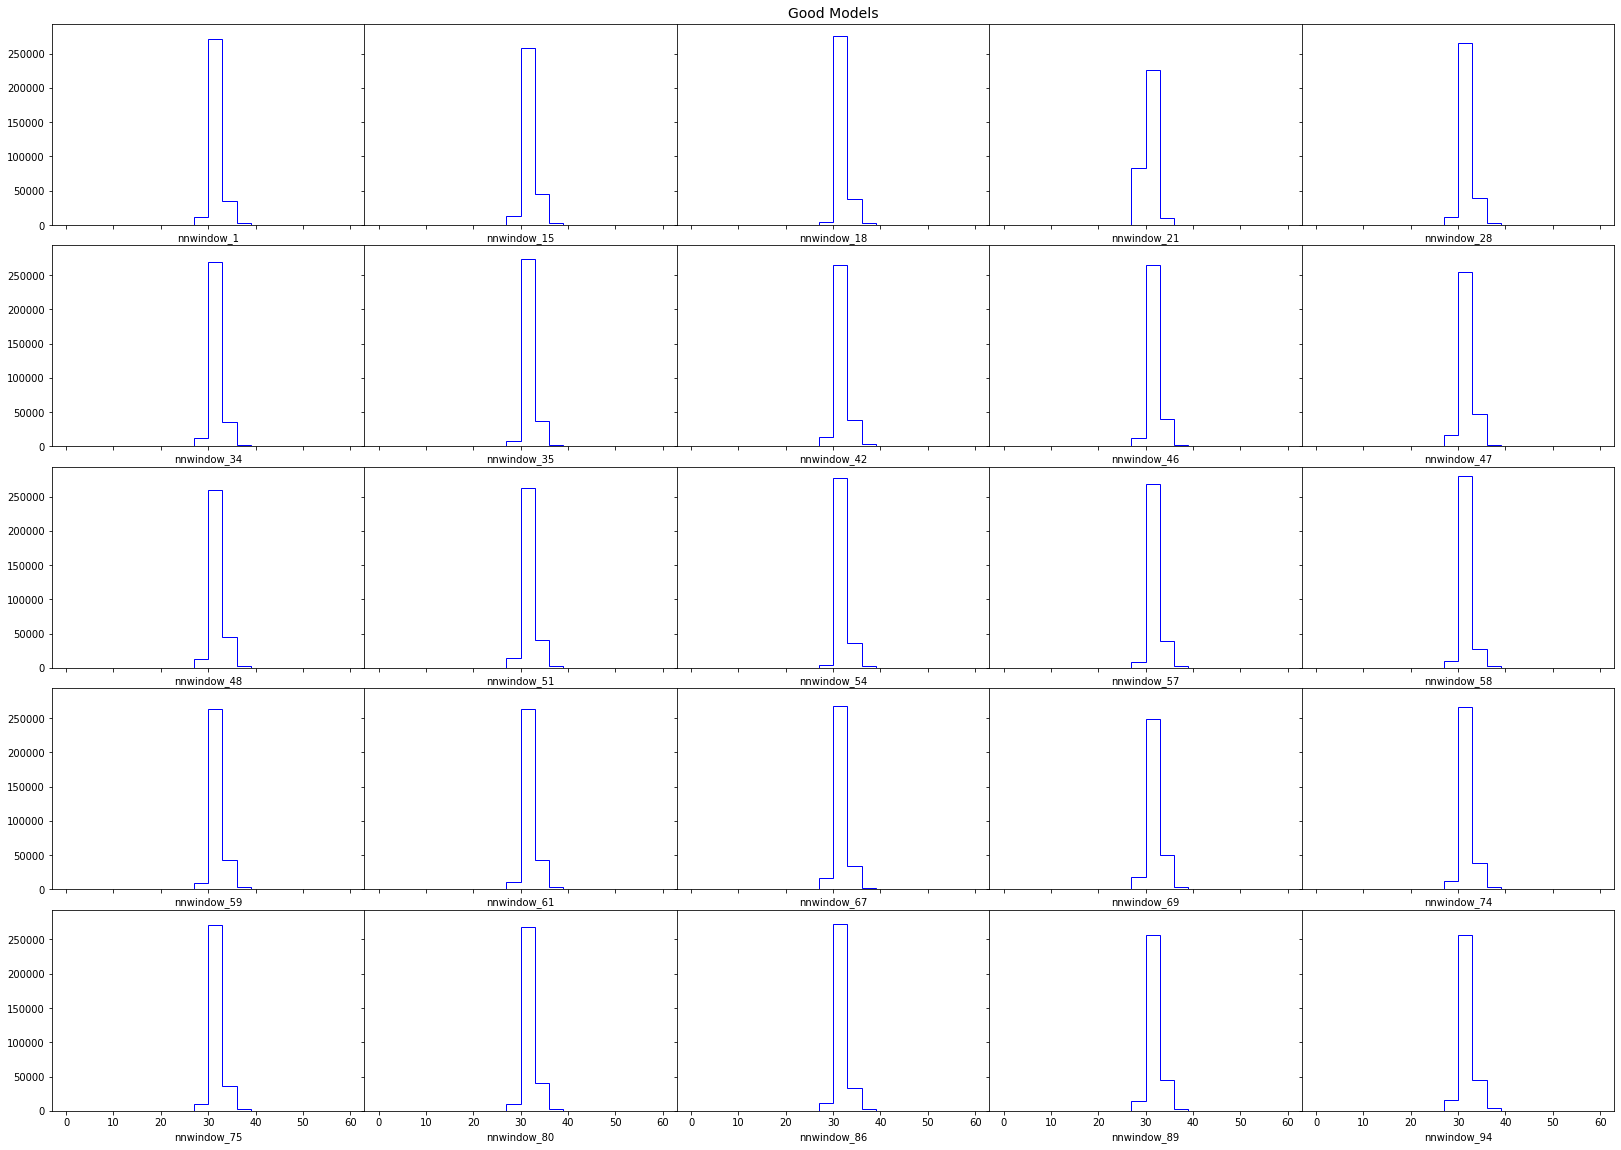

In [9]:
from time import time

models = good_models
output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/results'

ncols, nrows = len(models)//5, 5
fg, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(30, 12), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.0, hspace=0.1)
ax = ax.flatten()
fig = plt.gcf()
fig.set_size_inches(28, 20)

t0 = time()
kw = dict(histtype='step', bins=20, range=(0,60), color='b')
iterations = ncols * nrows
for i, mod_i in enumerate(models):
    #print(f'running {i+1}/{iterations}')
    nn = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_{mod_i}.hp256.fits')[hpix]
    ax[i].hist(nn, **kw)
    ax[i].set(xlabel=f'nnwindow_{mod_i}')
ax[2].set_title('Good Models', fontsize=14)
print(f'finished at {time()-t0} s')
plt.show()

finished at 0.46968626976013184 s


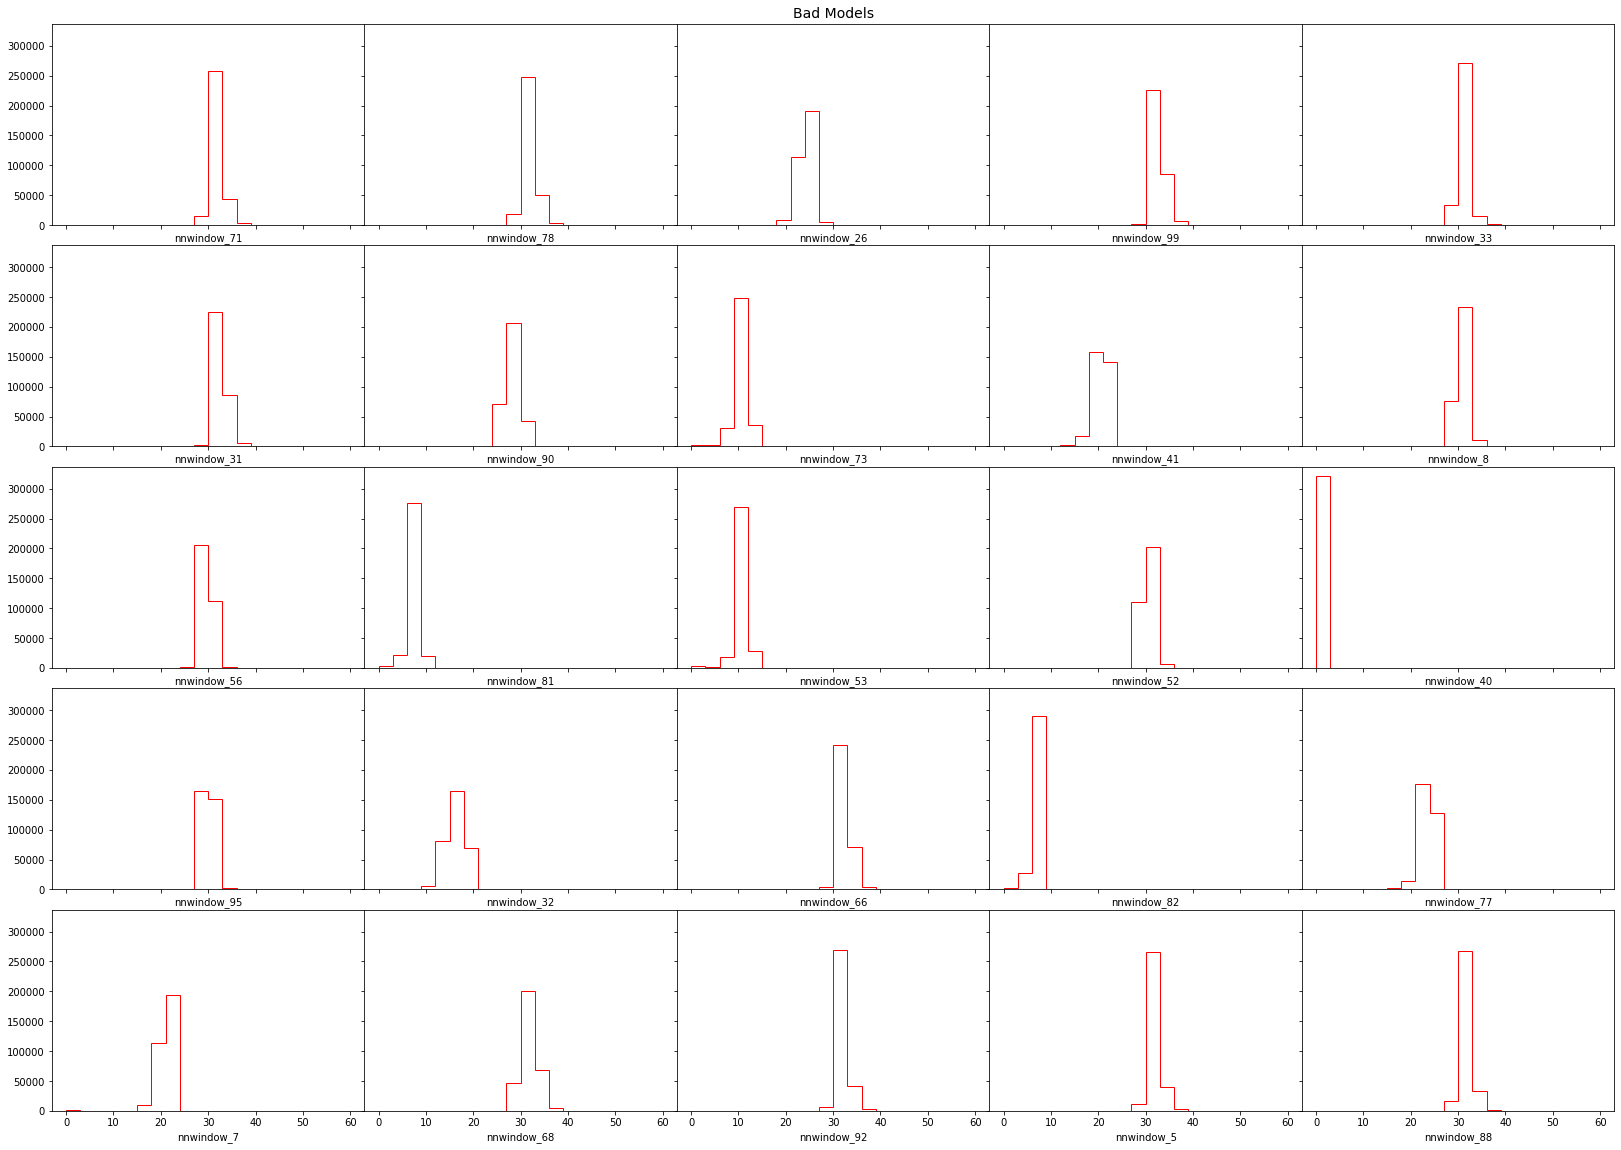

In [10]:
from time import time

np.random.seed(0)
models = np.random.permutation(bad_models)[:25]
output_dir = f'/global/cscratch1/sd/arosado/test_sysnet/results'

ncols, nrows = len(models)//5, 5
fg, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(30, 12), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.0, hspace=0.1)
ax = ax.flatten()
fig = plt.gcf()
fig.set_size_inches(28, 20)

t0 = time()
kw = dict(histtype='step', bins=20, range=(0,60), color='r')
iterations = ncols * nrows
for i, mod_i in enumerate(models):
    #print(f'running {i+1}/{iterations}')
    nn = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nnwindow_{mod_i}.hp256.fits')[hpix]
    ax[i].hist(nn, **kw)
    ax[i].set(xlabel=f'nnwindow_{mod_i}')
ax[2].set_title('Bad Models', fontsize=14)
print(f'finished at {time()-t0} s')
plt.show()